This notebook was made on Colab, you just need to upload the 
`export-2019-11-04T21_29_04.108Z.json` file.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import pandas as pd
import numpy as np
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from multiprocessing import Pool
from functools import partial
    
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [0]:
def parallelize(data, func, num_of_processes=8):
    data_split = np.array_split(data, num_of_processes)
    pool = Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)

def parallelize_on_rows(data, func, num_of_processes=64):
    return parallelize(data, partial(run_on_subset, func), num_of_processes)

def save_images(row):
    img = Image.open(BytesIO(requests.get(row["Labeled Data"]).content))
    mask = Image.open(BytesIO(requests.get(row["segmentationMaskURL"]).content))
    img.save(str(img_out_path) + str(row["ID"]) + ".jpg")
    mask.save(str(mask_out_path) + str(row["ID"]) + ".png")

In [0]:
# Change this to suit your environment
img_out_path = "data/images/"
mask_out_path = "data/masks/"
os.mkdir('data')
os.mkdir(img_out_path)
os.mkdir(mask_out_path)

In [0]:
label_df = pd.read_json("/content/export-2019-11-04T21_29_04.108Z.json"). \
    drop(["DataRow ID", "Project Name", "Created By", "Created At", "Agreement", "Benchmark Agreement",
          "Benchmark Reference ID", "Benchmark ID", "Dataset Name", "Reviews","Seconds to Label",
          "Updated At"], axis=1)

label_df["segmentationMaskURL"] = label_df["Label"].apply(lambda x: dict(x).get('segmentationMaskURL'))
label_df.drop(["Label"], axis=1, inplace=True)
label_df.drop(index=6650, inplace=True) # removed as mask download link is not present

In [7]:
%%time 
parallelize_on_rows(label_df, save_images)

CPU times: user 4.08 s, sys: 3.22 s, total: 7.3 s
Wall time: 26min 34s


0       None
1       None
2       None
3       None
4       None
        ... 
7597    None
7598    None
7599    None
7600    None
7601    None
Length: 7601, dtype: object

In [8]:
len(os.listdir(img_out_path)), len(os.listdir(mask_out_path)), len(label_df)

(7601, 7601, 7601)

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [10]:
gpu_mem_get_all()

[GPUMemory(total=16280, free=16270, used=10)]

In [0]:
# From: https://forums.fast.ai/t/cant-do-segmentation-cuda-error-device-side-assert-triggered/37507/5?u=andandandand
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [12]:
fnames = get_image_files(img_out_path)
mask_names = get_image_files(mask_out_path)
gpu_mem_get_all()

[GPUMemory(total=16280, free=16270, used=10)]

In [13]:
get_y_fn = lambda x : Path(mask_out_path)/f'{x.stem}.png' #mask_out_path / f'{x.stem}{x.suffix}' # Fixed
gpu_mem_get_free_no_cache()
gpu_mem_get_all()

[GPUMemory(total=16280, free=16270, used=10)]

data/images/ck1yvlqwlnz0l0748r90h9xmc.jpg


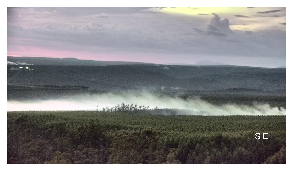

In [16]:
img_f = fnames[11]
print(img_f)
img = open_image(img_f)
img.show(figsize=(5,5))

data/masks/ck1yvlqwlnz0l0748r90h9xmc.png


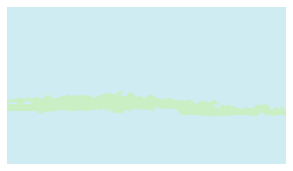

In [17]:
mask_name = get_y_fn(img_f)
print(mask_name)
mask = open_mask(mask_name)
mask.show(figsize=(5,5))

In [0]:
codes =['No-Smoke', 'smoke']
bs = 4
size = 256

In [0]:
data = (SegItemListCustom.from_folder(img_out_path)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_rand_pct(0.2, seed=42)
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes)
        #How to label? -> use the label functiontrain_path on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> use tfms with a size of 256, also transform the label images
        .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
## I am trying Attention methods in decoders in Unet models.
## Will be uploading all the training and prediction codes in a day or two.
## If anyone wants to go ahead and read more on the model, you can find it here
## https://github.com/bestfitting/kaggle/blob/master/siim_acr/src/networks/unet_resnet.py
## Original Paper can be found here - https://eccv2018.org/openaccess/content_ECCV_2018/papers/Sanghyun_Woo_Convolutional_Block_Attention_ECCV_2018_paper.pdf
## Pretrained Encoder with attention can also be used for Unet, you can find them 
## https://github.com/Jongchan/attention-module